In [1]:
import pandas as pd
import numpy as np
df = pd.read_csv('imdb_movie_dataset.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Rank                1000 non-null   int64  
 1   Title               1000 non-null   object 
 2   Genre               1000 non-null   object 
 3   Description         1000 non-null   object 
 4   Director            1000 non-null   object 
 5   Actors              1000 non-null   object 
 6   Year                1000 non-null   int64  
 7   Runtime (Minutes)   1000 non-null   int64  
 8   Rating              1000 non-null   float64
 9   Votes               1000 non-null   int64  
 10  Revenue (Millions)  872 non-null    float64
 11  Metascore           936 non-null    float64
dtypes: float64(3), int64(4), object(5)
memory usage: 93.9+ KB


In [2]:
# Check exact missing count before fixing
print("Missing values before cleaning:")
print(df.isnull().sum())

# 1. Fill missing Revenue with the median (middle value)
# Median is often better than mean for revenue because it isn't skewed by huge blockbusters
df['Revenue (Millions)'] = df['Revenue (Millions)'].fillna(df['Revenue (Millions)'].median())

# 2. Fill missing Metascores with the average (mean)
df['Metascore'] = df['Metascore'].fillna(df['Metascore'].mean())

print("\nMissing values after cleaning:")
print(df.isnull().sum())

Missing values before cleaning:
Rank                    0
Title                   0
Genre                   0
Description             0
Director                0
Actors                  0
Year                    0
Runtime (Minutes)       0
Rating                  0
Votes                   0
Revenue (Millions)    128
Metascore              64
dtype: int64

Missing values after cleaning:
Rank                  0
Title                 0
Genre                 0
Description           0
Director              0
Actors                0
Year                  0
Runtime (Minutes)     0
Rating                0
Votes                 0
Revenue (Millions)    0
Metascore             0
dtype: int64


In [3]:
# Clean the column names: lowercase, replace spaces with _, and remove ()
df.columns = [c.lower().replace(' ', '_').replace('(', '').replace(')', '') for c in df.columns]

# Display new names to confirm
print("New Column Names:", df.columns.tolist())

New Column Names: ['rank', 'title', 'genre', 'description', 'director', 'actors', 'year', 'runtime_minutes', 'rating', 'votes', 'revenue_millions', 'metascore']


In [4]:
# 1. Ensure the description column has no missing values
df = df.dropna(subset=['description'])

# 2. Convert all text in description to lowercase
df['description'] = df['description'].str.lower()

# 3. Remove the 'rank' column as it doesn't help with success prediction
if 'rank' in df.columns:
    df = df.drop(columns=['rank'])

print("Text cleaning and column dropping complete.")

Text cleaning and column dropping complete.


In [5]:
# Show the first 5 rows of the perfectly clean data
df.head()

,title,genre,description,director,actors,year,runtime_minutes,rating,votes,revenue_millions,metascore
0,Guardians of the Galaxy,"Action,Adventure,Sci-Fi",a group of intergalactic criminals are forced ...,James Gunn,"Chris Pratt, Vin Diesel, Bradley Cooper, Zoe S...",2014,121,8.1,757074,333.13,76.0
1,Prometheus,"Adventure,Mystery,Sci-Fi","following clues to the origin of mankind, a te...",Ridley Scott,"Noomi Rapace, Logan Marshall-Green, Michael Fa...",2012,124,7.0,485820,126.46,65.0
2,Split,"Horror,Thriller",three girls are kidnapped by a man with a diag...,M. Night Shyamalan,"James McAvoy, Anya Taylor-Joy, Haley Lu Richar...",2016,117,7.3,157606,138.12,62.0
3,Sing,"Animation,Comedy,Family","in a city of humanoid animals, a hustling thea...",Christophe Lourdelet,"Matthew McConaughey,Reese Witherspoon, Seth Ma...",2016,108,7.2,60545,270.32,59.0
4,Suicide Squad,"Action,Adventure,Fantasy",a secret government agency recruits some of th...,David Ayer,"Will Smith, Jared Leto, Margot Robbie, Viola D...",2016,123,6.2,393727,325.02,40.0


In [6]:
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer

# Download the VADER lexicon (the dictionary of words and their emotional scores)
nltk.download('vader_lexicon')

# Initialize the analyzer
sia = SentimentIntensityAnalyzer()

print("VADER Sentiment Analyzer is ready!")

VADER Sentiment Analyzer is ready!


[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


In [7]:
# We create a function to get the 'compound' score for each description
def get_sentiment(text):
    return sia.polarity_scores(text)['compound']

# Apply the function to the 'description' column
df['sentiment_score'] = df['description'].apply(get_sentiment)

# Let's see the results
print("Sentiment scores calculated!")
df[['title', 'description', 'sentiment_score']].head()

Sentiment scores calculated!


,title,description,sentiment_score
0,Guardians of the Galaxy,a group of intergalactic criminals are forced ...,-0.8360
1,Prometheus,"following clues to the origin of mankind, a te...",0.2755
2,Split,three girls are kidnapped by a man with a diag...,-0.3818
3,Sing,"in a city of humanoid animals, a hustling thea...",0.7096
4,Suicide Squad,a secret government agency recruits some of th...,-0.0240


In [8]:
# Categorize based on standard VADER thresholds
def label_sentiment(score):
    if score >= 0.05:
        return 'Positive'
    elif score <= -0.05:
        return 'Negative'
    else:
        return 'Neutral'

df['sentiment_type'] = df['sentiment_score'].apply(label_sentiment)

# Check the distribution of sentiments
print(df['sentiment_type'].value_counts())

sentiment_type
Negative    511
Positive    362
Neutral     127
Name: count, dtype: int64


In [9]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, r2_score

# 1. Convert 'Genre' into multiple columns of 0s and 1s
df_final = pd.get_dummies(df, columns=['genre'], drop_first=True)

# 2. Define our Features (X) and our Target (y)
# We want to use budget, rating, and our new sentiment_score to predict revenue
features = ['votes', 'rating', 'metascore', 'sentiment_score']
# Note: We include genres too!
X = df_final[features + [col for col in df_final.columns if 'genre_' in col]]
y = df_final['revenue_millions']

print("Features and Target are ready!")

Features and Target are ready!


In [10]:
# Split: 80% of data for training, 20% for testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Training on {len(X_train)} movies, testing on {len(X_test)} movies.")

Training on 800 movies, testing on 200 movies.


In [11]:
# Initialize and train the Linear Regression model
model = LinearRegression()
model.fit(X_train, y_train)

# Make predictions on the hidden test data
predictions = model.predict(X_test)

print("Model training complete!")

Model training complete!


In [12]:
# Calculate the error
mae = mean_absolute_error(y_test, predictions)
r2 = r2_score(y_test, predictions)

print(f"Average Error: ${mae:.2f} Million")
print(f"Model Accuracy (R2 Score): {r2:.2f}")

Average Error: $49.40 Million
Model Accuracy (R2 Score): 0.53


/tmp/ipython-input-3510234943.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=genre_sentiment.index, y=genre_sentiment.values, palette='viridis')


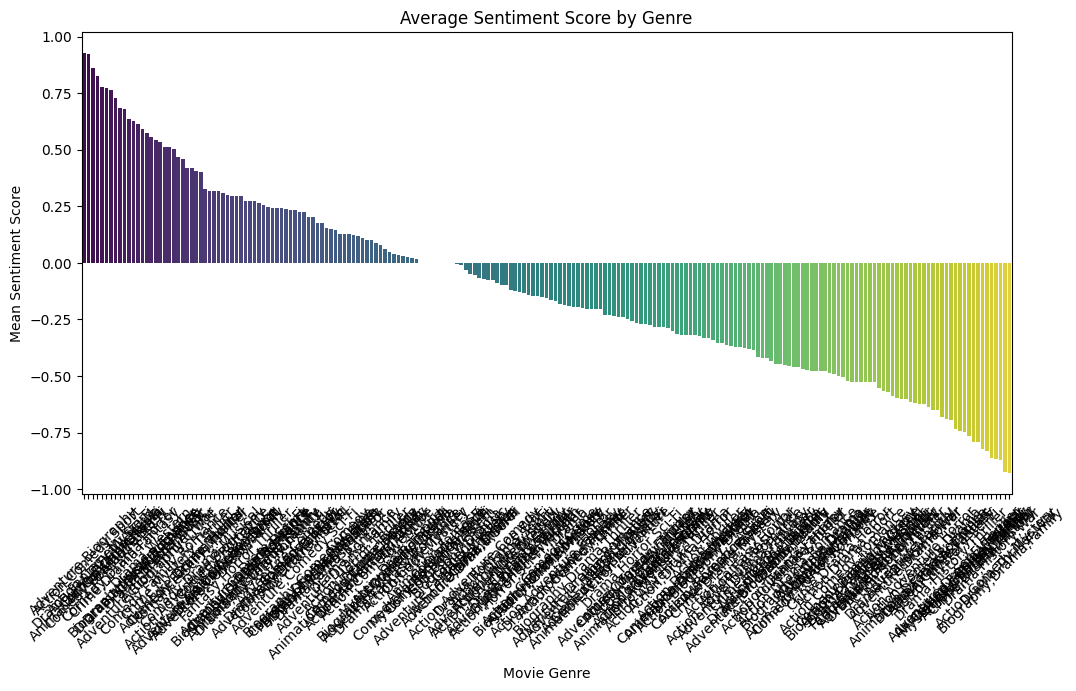

In [13]:
import seaborn as sns
import matplotlib.pyplot as plt

# 1. Calculate average sentiment per genre
genre_sentiment = df.groupby('genre')['sentiment_score'].mean().sort_values(ascending=False)

# 2. Create the Bar Chart
plt.figure(figsize=(12, 6))
sns.barplot(x=genre_sentiment.index, y=genre_sentiment.values, palette='viridis')
plt.xticks(rotation=45)
plt.title('Average Sentiment Score by Genre')
plt.xlabel('Movie Genre')
plt.ylabel('Mean Sentiment Score')
plt.show()

/tmp/ipython-input-2982890922.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=genre_sentiment.index, y=genre_sentiment.values, palette='viridis')


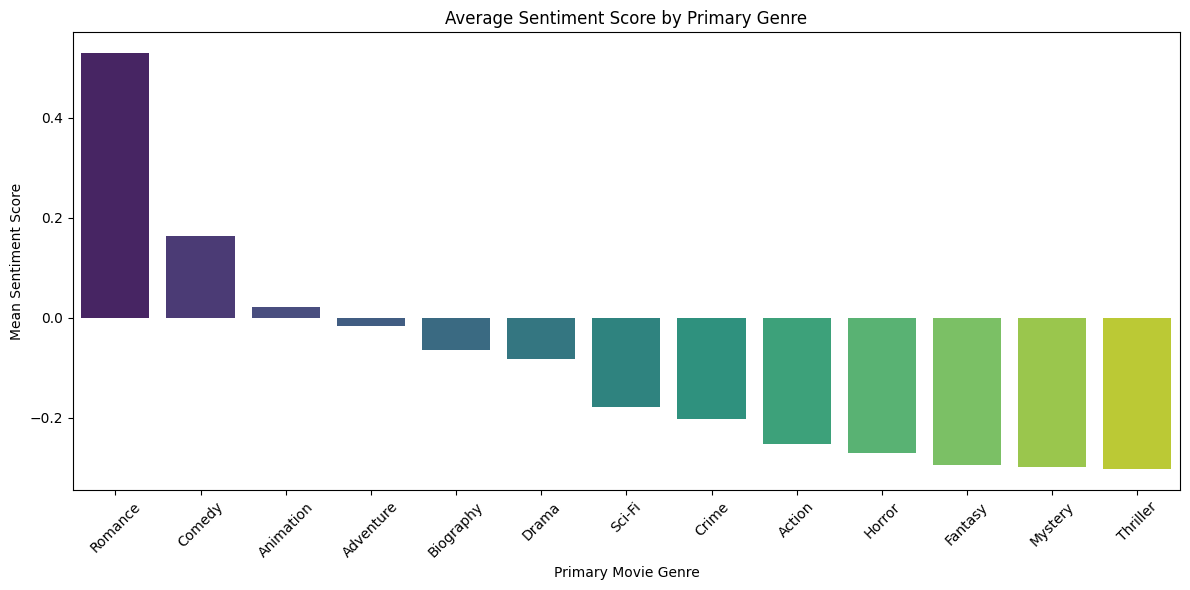

In [14]:
# 1. Create a new column that only takes the first word of the genre
df['primary_genre'] = df['genre'].str.split(',').str[0]

# 2. Re-calculate the average sentiment using the simplified column
genre_sentiment = df.groupby('primary_genre')['sentiment_score'].mean().sort_values(ascending=False)

# 3. Re-draw the chart
plt.figure(figsize=(12, 6))
sns.barplot(x=genre_sentiment.index, y=genre_sentiment.values, palette='viridis')

plt.xticks(rotation=45)
plt.title('Average Sentiment Score by Primary Genre')
plt.xlabel('Primary Movie Genre')
plt.ylabel('Mean Sentiment Score')
plt.tight_layout() # This prevents labels from getting cut off
plt.show()

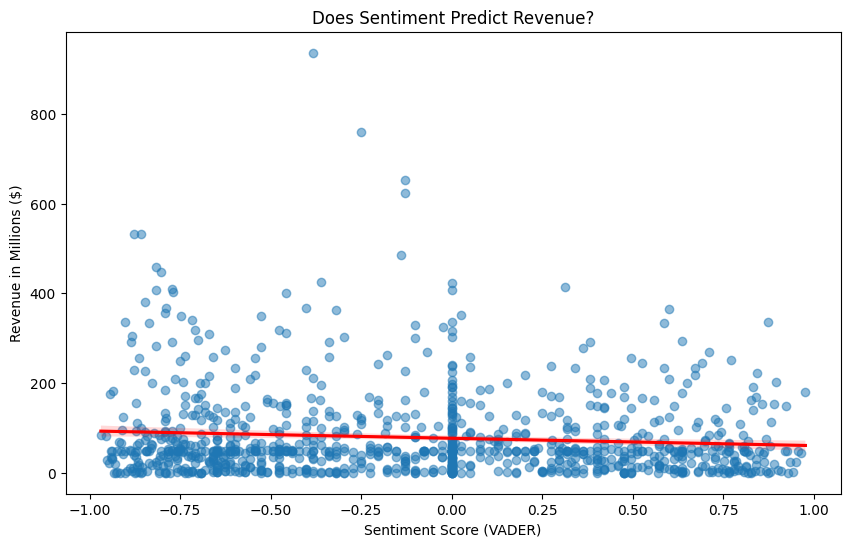

In [15]:
# Create a Scatter Plot with a 'Trend Line' (Regression Line)
plt.figure(figsize=(10, 6))
sns.regplot(data=df, x='sentiment_score', y='revenue_millions',
            scatter_kws={'alpha':0.5}, line_kws={'color':'red'})

plt.title('Does Sentiment Predict Revenue?')
plt.xlabel('Sentiment Score (VADER)')
plt.ylabel('Revenue in Millions ($)')
plt.show()

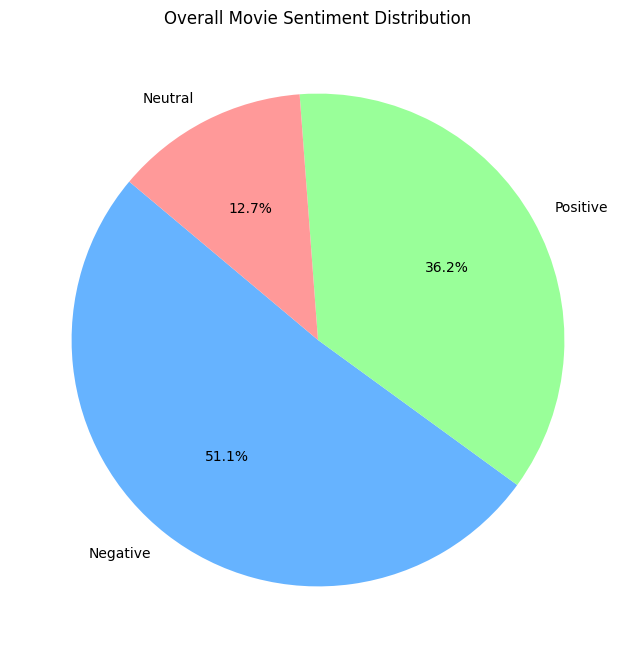

In [16]:
# Create a Pie Chart
sentiment_counts = df['sentiment_type'].value_counts()

plt.figure(figsize=(8, 8))
plt.pie(sentiment_counts, labels=sentiment_counts.index, autopct='%1.1f%%',
        colors=['#66b3ff','#99ff99','#ff9999'], startangle=140)
plt.title('Overall Movie Sentiment Distribution')
plt.show()

In [17]:
df.to_csv('sentiment_results.csv', index=False)